# 1) Importing libraries 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
np.warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import missingno as msno

In [4]:
from pandasql import sqldf

In [5]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [6]:
from sklearn.model_selection import KFold

In [7]:
import dask.dataframe as dd

In [8]:
np.random.seed(51)

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2) Reading train_metadata_kaggle & test_metadata_kaggle

In [10]:
%%time
train_metadata_kaggle = dd.read_csv('klm_train.csv')
test_metadata_kaggle = dd.read_csv('klm_test.csv')
train_metadata_kaggle = train_metadata_kaggle.compute()
test_metadata_kaggle = test_metadata_kaggle.compute()
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 64) (3492890, 63)
CPU times: user 1min 39s, sys: 6.32 s, total: 1min 45s
Wall time: 19 s


In [11]:
test_id = test_metadata_kaggle['object_id']

In [12]:
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 64) (3492890, 63)


In [13]:
train_metadata_kaggle.head()

,object_id,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness,flux__length,flux__longest_strike_above_mean,flux__longest_strike_below_mean,flux__mean_abs_change,flux__mean_change,flux_by_flux_ratio_sq__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_below_mean,mjd__mean_abs_change,mjd__mean_change,mjd_diff_det,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,haversine,latlon1,hostgal_photoz_certain
0,615,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835268,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,-327.742307,1761.066406,-14.306331,-5.373326,205.036926,1628.427737,-1.475181,0.128917,22370.594834,2806.374162,-1.255123,0.415580,7780.500807,2805.598113,-1.409885,0.339918,7024.003068,2536.068846,-1.449858,0.293128,3245.366349,2741.539785,-1.548319,0.200096,2704.641265,2893.344217,-1.592820,0.125268,352.0,19.0,29.0,202.114067,1.999688,35.0,4.0,2.631898,2.631898,873.7903,0.0000,0.0000,NaN,0.017,92,0.319006,-1.528827,0.000000
1,713,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,-4.884564,29.506064,-20.730002,-6.040676,190.427851,299.586559,-1.014003,0.260052,57.109047,192.539229,-1.097170,-0.087865,44.477327,191.057528,-1.188472,-0.022678,55.270113,212.522263,-1.142896,-0.167176,50.414646,203.892482,-1.190245,-0.064134,100.473776,143.963093,-0.797047,0.218182,350.0,50.0,73.0,2.935177,-0.050944,199.0,8.0,14.352571,14.352571,846.8017,1.6267,0.2552,45.4063,0.007,88,1.698939,3.258921,2.099614
2,730,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,25.373110,66.469870,29.315018,2.619697,3.461790,4.729538,0.474215,0.356910,7.334944,13.515895,0.976374,0.471342,124.845250,119.500254,5.131290,2.385066,168.280524,162.799417,7.125665,2.662075,219.745132,202.532898,6.081065,2.537802,231.509177,199.286370,3.583130,1.680352,330.0,13.0,32.0,4.227614,-0.008131,4.0,222.0,3.580623,3.580623,78.7737,0.2262,0.0157,40.2561,0.021,42,1.818030,3.128522,0.229779
3,745,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,152.835617,236.289675,26.521968,1.546038,129.421659,123.298327,4.629801,2.023211,320.174052,280.440312,50.868880,7.007099,543.845781,491.548270,36.088137,5.688194,807.123762,710.721942,16.392533,3.751603,735.528417,680.055280,13.747434,3.476420,591.037583,523.503586,12.134629,3.170857,351.0,19.0,115.0,7.065548,0.008044,4.0,201.0,2.061453,2.061453,123.6872,0.2813,1.1523,40.7951,0.007,90,0.495223,6.893743,0.890445
4,1124,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174,87.856390,160.143942,22.411225,1.822792,41.639721,32.987125,0.822496,-0.332169,268.808929,207.812015,6.112295,2.377222,5

# 3) reading train_metadata_final & test_metadata_final

In [14]:
"""%%time
train_metadata = dd.read_csv('train_metadata_final.csv')
test_metadata = dd.read_csv('test_metadata_final.csv')
train_metadata = train_metadata.compute()
test_metadata = test_metadata.compute()
print(train_metadata.shape,test_metadata.shape)"""

"%%time\ntrain_metadata = dd.read_csv('train_metadata_final.csv')\ntest_metadata = dd.read_csv('test_metadata_final.csv')\ntrain_metadata = train_metadata.compute()\ntest_metadata = test_metadata.compute()\nprint(train_metadata.shape,test_metadata.shape)"

In [15]:
"""y = train_metadata['target']
del train_metadata['target']
gc.collect()"""

"y = train_metadata['target']\ndel train_metadata['target']\ngc.collect()"

# 4) Reading created_column

In [16]:
"""created_column = pd.read_csv('hostgal_specz.csv',header=None)
created_column.shape[0] == train_metadata_kaggle.shape[0] + test_metadata_kaggle.shape[0]
created_column.columns = ['object_id','hostgal_specz']
print(train_metadata_kaggle.shape)"""

"created_column = pd.read_csv('hostgal_specz.csv',header=None)\ncreated_column.shape[0] == train_metadata_kaggle.shape[0] + test_metadata_kaggle.shape[0]\ncreated_column.columns = ['object_id','hostgal_specz']\nprint(train_metadata_kaggle.shape)"

# 5) Removing duplicated_columns from train_metadata & test_metadata

In [17]:
"""will_be_deleted_columns = ['NG_min_flux','NG_max_flux','NG_std_flux','NG_mean_flux','NG_median_flux',
                          'NG_min_flux_err','NG_max_flux_err','NG_std_flux_err','NG_mean_flux_err','NG_median_flux_err',
                          'NG_mean_detected','hostgal_photoz','hostgal_photoz_err','mwebv']"""

"will_be_deleted_columns = ['NG_min_flux','NG_max_flux','NG_std_flux','NG_mean_flux','NG_median_flux',\n                          'NG_min_flux_err','NG_max_flux_err','NG_std_flux_err','NG_mean_flux_err','NG_median_flux_err',\n                          'NG_mean_detected','hostgal_photoz','hostgal_photoz_err','mwebv']"

In [18]:
"""%%time
train_metadata.drop(will_be_deleted_columns,inplace=True , axis=1)
test_metadata.drop(will_be_deleted_columns,inplace=True , axis=1)
gc.collect()"""

'%%time\ntrain_metadata.drop(will_be_deleted_columns,inplace=True , axis=1)\ntest_metadata.drop(will_be_deleted_columns,inplace=True , axis=1)\ngc.collect()'

# 6) Adding hostgal_specz to train_metadata_kaggle

In [19]:
"""%%time
train_metadata_kaggle = train_metadata_kaggle.merge(right = created_column ,how='left',on = 'object_id')"""

"%%time\ntrain_metadata_kaggle = train_metadata_kaggle.merge(right = created_column ,how='left',on = 'object_id')"

# 7) Adding hostgal_specz to train_metadata_kaggle

In [20]:
"""%%time
test_metadata_kaggle = test_metadata_kaggle.merge(right = created_column ,how='left',on = 'object_id')"""

"%%time\ntest_metadata_kaggle = test_metadata_kaggle.merge(right = created_column ,how='left',on = 'object_id')"

# 8) Creating train and test datasets

In [21]:
#temp = train_metadata_kaggle.merge(right = train_metadata[[x for x in train_metadata.columns if x not in ignored_columns ]] ,how='left',on = 'object_id')

In [22]:
"""#train
train_metadata_kaggle['flux_diff_btw_mean_and_min'] = train_metadata_kaggle['flux_mean'] - train_metadata_kaggle['flux_min']
train_metadata_kaggle['flux_diff_btw_mean_and_max'] = train_metadata_kaggle['flux_max'] - train_metadata_kaggle['flux_mean']
train_metadata_kaggle['flux_std_divided_by_skew'] = train_metadata_kaggle['flux_std'] / train_metadata_kaggle['flux_skew']

#test
test_metadata_kaggle['flux_diff_btw_mean_and_min'] = test_metadata_kaggle['flux_mean'] - test_metadata_kaggle['flux_min']
test_metadata_kaggle['flux_diff_btw_mean_and_max'] = test_metadata_kaggle['flux_max'] - test_metadata_kaggle['flux_mean']
test_metadata_kaggle['flux_std_divided_by_skew'] = test_metadata_kaggle['flux_std'] / test_metadata_kaggle['flux_skew']"""

"#train\ntrain_metadata_kaggle['flux_diff_btw_mean_and_min'] = train_metadata_kaggle['flux_mean'] - train_metadata_kaggle['flux_min']\ntrain_metadata_kaggle['flux_diff_btw_mean_and_max'] = train_metadata_kaggle['flux_max'] - train_metadata_kaggle['flux_mean']\ntrain_metadata_kaggle['flux_std_divided_by_skew'] = train_metadata_kaggle['flux_std'] / train_metadata_kaggle['flux_skew']\n\n#test\ntest_metadata_kaggle['flux_diff_btw_mean_and_min'] = test_metadata_kaggle['flux_mean'] - test_metadata_kaggle['flux_min']\ntest_metadata_kaggle['flux_diff_btw_mean_and_max'] = test_metadata_kaggle['flux_max'] - test_metadata_kaggle['flux_mean']\ntest_metadata_kaggle['flux_std_divided_by_skew'] = test_metadata_kaggle['flux_std'] / test_metadata_kaggle['flux_skew']"

# Starting from here

In [23]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

In [24]:
temp = train_metadata_kaggle.copy()

In [25]:
y = temp['target']

In [26]:
del temp['target']

In [27]:
print(temp.shape)

(7848, 63)


In [28]:
temp.head()

,object_id,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness,flux__length,flux__longest_strike_above_mean,flux__longest_strike_below_mean,flux__mean_abs_change,flux__mean_change,flux_by_flux_ratio_sq__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_below_mean,mjd__mean_abs_change,mjd__mean_change,mjd_diff_det,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,haversine,latlon1,hostgal_photoz_certain
0,615,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835268,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,-327.742307,1761.066406,-14.306331,-5.373326,205.036926,1628.427737,-1.475181,0.128917,22370.594834,2806.374162,-1.255123,0.415580,7780.500807,2805.598113,-1.409885,0.339918,7024.003068,2536.068846,-1.449858,0.293128,3245.366349,2741.539785,-1.548319,0.200096,2704.641265,2893.344217,-1.592820,0.125268,352.0,19.0,29.0,202.114067,1.999688,35.0,4.0,2.631898,2.631898,873.7903,0.0000,0.0000,NaN,0.017,0.319006,-1.528827,0.000000
1,713,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,-4.884564,29.506064,-20.730002,-6.040676,190.427851,299.586559,-1.014003,0.260052,57.109047,192.539229,-1.097170,-0.087865,44.477327,191.057528,-1.188472,-0.022678,55.270113,212.522263,-1.142896,-0.167176,50.414646,203.892482,-1.190245,-0.064134,100.473776,143.963093,-0.797047,0.218182,350.0,50.0,73.0,2.935177,-0.050944,199.0,8.0,14.352571,14.352571,846.8017,1.6267,0.2552,45.4063,0.007,1.698939,3.258921,2.099614
2,730,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,25.373110,66.469870,29.315018,2.619697,3.461790,4.729538,0.474215,0.356910,7.334944,13.515895,0.976374,0.471342,124.845250,119.500254,5.131290,2.385066,168.280524,162.799417,7.125665,2.662075,219.745132,202.532898,6.081065,2.537802,231.509177,199.286370,3.583130,1.680352,330.0,13.0,32.0,4.227614,-0.008131,4.0,222.0,3.580623,3.580623,78.7737,0.2262,0.0157,40.2561,0.021,1.818030,3.128522,0.229779
3,745,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,152.835617,236.289675,26.521968,1.546038,129.421659,123.298327,4.629801,2.023211,320.174052,280.440312,50.868880,7.007099,543.845781,491.548270,36.088137,5.688194,807.123762,710.721942,16.392533,3.751603,735.528417,680.055280,13.747434,3.476420,591.037583,523.503586,12.134629,3.170857,351.0,19.0,115.0,7.065548,0.008044,4.0,201.0,2.061453,2.061453,123.6872,0.2813,1.1523,40.7951,0.007,0.495223,6.893743,0.890445
4,1124,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174,87.856390,160.143942,22.411225,1.822792,41.639721,32.987125,0.822496,-0.332169,268.808929,207.812015,6.112295,2.377222,594.150153,498.50982

# 9) Writing helpful functions

In [29]:
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

train_id = temp['object_id']
del temp['object_id']

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [30]:
"""from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
print(list(le.classes_))
y = pd.Series(le.transform(y))
print("="*90)
print(le.inverse_transform( y.head() ))"""
#y = pd.get_dummies( y )

'from sklearn import preprocessing\nle = preprocessing.LabelEncoder()\nle.fit(y)\nprint(list(le.classes_))\ny = pd.Series(le.transform(y))\nprint("="*90)\nprint(le.inverse_transform( y.head() ))'

In [31]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)

In [32]:
ss = StandardScaler()
full_train_ss = ss.fit_transform(temp)

In [42]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

In [43]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [44]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [45]:
from keras.layers import PReLU, ReLU, Activation

In [46]:
K.clear_session()
def build_model(dropout_rate=0.25, activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    
    return model

In [47]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

In [48]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [49]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

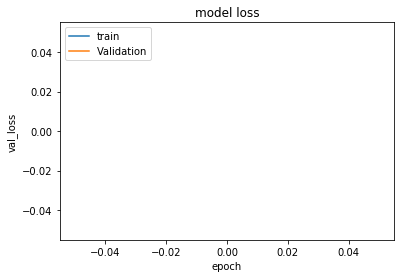

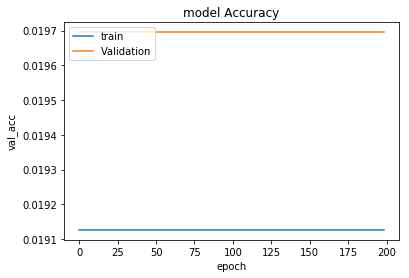

Loading Best Model


ValueError: Dimension 0 in both shapes must be equal, but are 62 and 98. Shapes are [62,512] and [98,512]. for 'Assign' (op: 'Assign') with input shapes: [62,512], [98,512].

In [50]:
%%time
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 200
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    K.clear_session()
    model = build_model(dropout_rate=0.25, activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

In [51]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [49]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [50]:
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

26398

Normalized confusion matrix
[[9.34e-01 0.00e+00 1.99e-02 0.00e+00 0.00e+00 1.99e-02 0.00e+00 0.00e+00
  2.65e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 7.86e-01 0.00e+00 3.03e-02 3.84e-02 0.00e+00 1.62e-02 1.82e-02
  0.00e+00 3.84e-02 2.02e-03 4.85e-02 0.00e+00 2.22e-02]
 [9.74e-03 0.00e+00 9.71e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  3.25e-03 0.00e+00 1.08e-03 0.00e+00 1.52e-02 0.00e+00]
 [0.00e+00 1.34e-01 0.00e+00 3.01e-01 1.88e-01 0.00e+00 6.54e-02 3.02e-02
  0.00e+00 9.22e-02 8.38e-04 1.57e-01 0.00e+00 3.19e-02]
 [0.00e+00 7.65e-02 0.00e+00 5.46e-02 4.97e-01 0.00e+00 3.28e-02 5.46e-03
  0.00e+00 1.26e-01 0.00e+00 2.08e-01 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 5.99e-02 0.00e+00 1.34e-01 1.76e-01 0.00e+00 2.05e-01 5.79e-02
  0.00e+00 2.62e-01 0.00e+00 9.50e-02 0.00e+00 1.03e-02]
 [0.00e+00 9.80e-03 0.00e+00 0.00e+00 9.80e-03 0.00e+00

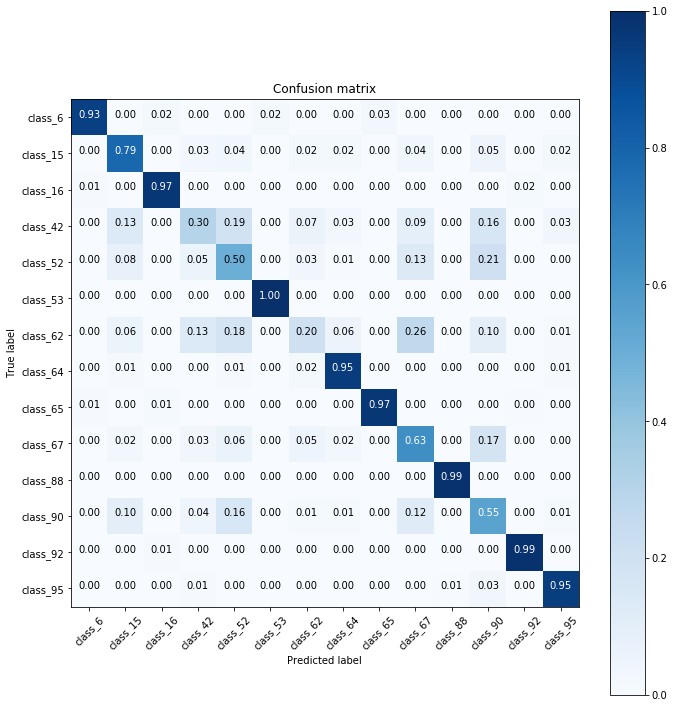

In [51]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [54]:
len(clfs)

5

In [ ]:
"""# HyperParameters
lr = 0.01
training_epochs = 100
batch_size = 32

# Network Parameters
n_hidden_1 = 1024 # number of neurons in 1st layer 
n_hidden_2 = 512 # number of neurons in 2nd layer 
n_input = 62 # 4 columns
n_classes = 14 #Output classes
steps = int(train_metadata_kaggle.shape[0]*0.8) # How many training data

#Resetting the graph
tf.reset_default_graph()

#Defining Placeholders
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
hold_prob1 = tf.placeholder(tf.float32)
hold_prob2 = tf.placeholder(tf.float32)

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1],mean = 0.0,stddev=0.2)),
    'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],mean = 0.0,stddev = 0.2)),
    'out': tf.Variable(tf.truncated_normal([n_hidden_2, n_classes],mean = 0.0,stddev = 0.2))
}
biases = {
    'b1': tf.Variable(tf.constant(0.1,shape = [n_hidden_1])),
    'b2': tf.Variable(tf.constant(0.1,shape = [n_hidden_2])),
    'out': tf.Variable(tf.constant(0.1,shape = [n_classes]))
}
"""

In [ ]:
"""# Create model
def multilayer_perceptron(x):
    # First Hidden Layer
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    #Applying RELU nonlinearity
    layer1_RELU = tf.nn.relu(layer_1)
    #Applying Dropout
    layer1_dropout = tf.nn.dropout(layer1_RELU,keep_prob=hold_prob1)
    # Second hidden layer
    layer_2 = tf.add(tf.matmul(layer1_dropout, weights['h2']), biases['b2'])
    #Applying TANH nonlinearity
    layer2_TANH = tf.nn.tanh(layer_2)
    #Applying Dropout
    layer2_dropout = tf.nn.dropout(layer2_TANH,keep_prob=hold_prob2)
    # Output layer
    out_layer = tf.matmul(layer2_dropout, weights['out']) + biases['out']
    return out_layer

# Building model
logits = multilayer_perceptron(X)"""

In [ ]:
"""class_weights = tf.constant([1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0])"""

In [ ]:
"""# Defining unweighted Loss Function
unweighted_loss_op = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y)
# Defining weighted Loss Function
#weighted_loss_op = tf.multiply(unweighted_loss_op, class_weights)

loss_op = tf.reduce_mean(unweighted_loss_op)

#Defining optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#Defining what to minimize
train_op = optimizer.minimize(loss_op)
# Initializing the variables
init = tf.global_variables_initializer()"""

In [ ]:
"""#Graph equations for Accuracy
matches = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))
acc = tf.reduce_mean(tf.cast(matches,tf.float32))"""

In [ ]:
"""%%time
folds = KFold(n_splits=5, shuffle=True, random_state=52)
clfs = []
importances = pd.DataFrame()"""

In [ ]:
"""steps - int( steps % batch_size )"""

In [ ]:
"""for fold_, (trn_, val_) in enumerate(folds.split(temp)):
    X_train, y_train = temp.iloc[trn_], y.iloc[trn_]
    X_cv, y_cv = temp.iloc[val_], y.iloc[val_]
    print(X_train.shape,y_train.shape,X_cv.shape,y_cv.shape)
    #Opening our Session
    with tf.Session() as sess:
        #Runnig initialization of variables
        sess.run(init)
        # Writing down the for loop for epochs
        for epoch in range(training_epochs):
            #For loop for batches
            for i in range(0,steps - int( steps % batch_size ),batch_size):
                #Getting training data to be fed into the graphs
                batch_x, batch_y = X_train[i:i+batch_size],y_train[i:i+batch_size]
                # Training batch by batch
                _, c = sess.run([train_op, loss_op], feed_dict={X: batch_x, Y: batch_y,hold_prob1:0.7,hold_prob2:0.8})
            #Feeding CV data to the graphs
            acc_on_cv,loss_on_cv,preds_on_cv = sess.run([acc,loss_op,tf.nn.softmax(logits)],
                                                        feed_dict = {X: X_cv,Y: y_cv,hold_prob1:1.0,hold_prob2:1.0})
            #Calculating AUC on Cross Validation data
            auc_on_cv = roc_auc_score(y_cv,preds_on_cv)
            #Printing CV statistics after each epoch
            print("Accuracy:",acc_on_cv,"Loss:",loss_on_cv,"AUC:",auc_on_cv)"""

        """#Feeding test data to the graphs
        acc_on_test,loss_on_test,preds_on_test = sess.run([acc,loss_op,tf.nn.softmax(logits)],
                                                        feed_dict = 
                                                                {X: X_test,
                                                                Y: y_test,
                                                                hold_prob1:1.0,
                                                                hold_prob2:1.0})
        #Calculating AUC on CV data
        auc_on_test = roc_auc_score(y_test,preds_on_test)
        print("Test Results:")
        print("Accuracy:",acc_on_test,"Loss:",loss_on_test,"AUC:",auc_on_test)

        print("All done")"""

In [ ]:
"""# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

def multi_weighted_logloss(y_true, y_preds):
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):

    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False"""

# 10 ) Defining hyperparameters

In [ ]:
%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
clfs = []
importances = pd.DataFrame()
lgb_params = {
'random_state':51,
'device': 'cpu', 
'objective': 'multiclass', 
'num_class': 14, 
'boosting_type': 'gbdt', 
'n_jobs': -1, 
'max_depth': 7, 
'n_estimators': 500, 
'subsample_freq': 2, 
'subsample_for_bin': 5000, 
'min_data_per_group': 100, 
'max_cat_to_onehot': 4, 
'cat_l2': 1.0, 
'cat_smooth': 59.5, 
'max_cat_threshold': 32, 
'metric_freq': 10, 
'verbosity': -1, 
'metric': 'multi_logloss', 
'xgboost_dart_mode': False, 
'uniform_drop': False, 
'colsample_bytree': 0.5, 
'drop_rate': 0.173, 
'learning_rate': 0.0267, 
'max_drop': 5, 
'min_child_samples': 10, 
'min_child_weight': 100.0, 
'min_split_gain': 0.1, 
'num_leaves': 7, 
'reg_alpha': 0.1, 
'reg_lambda': 0.00023, 
'skip_drop': 0.44, 
'subsample': 0.75}

In [ ]:
"""# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))"""

# 11) Training

In [ ]:
"""%%time
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
    val_x, val_y = temp.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, oof_preds[val_, :]))

    imp_df = pd.DataFrame()
    imp_df['feature'] = temp.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))"""

In [ ]:
"""print(list(temp.columns.values)[:5])"""

In [ ]:
"""print(list(test_metadata_kaggle.columns.values)[:5])"""

In [ ]:
"""imp_df.sort_values(by ='gain',ascending=False).reset_index(drop=True).head(20)"""

# 12) Preparing test data for scoring

In [ ]:
%%time
#temp_test = test_metadata_kaggle.merge(right = test_metadata[[x for x in test_metadata.columns if x not in ignored_columns ]] ,how='left',on = 'object_id')

In [55]:
%%time
temp_test = test_metadata_kaggle.copy()

CPU times: user 344 ms, sys: 484 ms, total: 829 ms
Wall time: 826 ms


In [56]:
del temp_test['object_id']

In [57]:
print(temp.shape,temp_test.shape)

(7848, 62) (3492890, 62)


In [58]:
list(temp.columns) == list(temp_test.columns)

True

In [59]:
temp_test = ss.transform(temp_test)

In [60]:
gc.enable()
del train_metadata_kaggle,test_metadata_kaggle
gc.collect()

10831

In [61]:
%%time
test_pred0 = pd.DataFrame()
test_pred1 = pd.DataFrame()
test_pred2 = pd.DataFrame()
test_pred3 = pd.DataFrame()
test_pred4 = pd.DataFrame()

list_of_df = [test_pred0,test_pred1,test_pred2,test_pred3,test_pred4]

for num,c in enumerate(clfs):
    print(num)
    for k in range(0,len(temp_test),500000):
        print(k)
        test_pred = pd.DataFrame(c.predict_proba(temp_test[ k:k+500000] ))
        list_of_df[num] = pd.concat([list_of_df[num],test_pred],axis=0)
        del test_pred

0
0
500000
1000000
1500000
2000000
2500000
3000000
1
0
500000
1000000
1500000
2000000
2500000
3000000
2
0
500000
1000000
1500000
2000000
2500000
3000000
3
0
500000
1000000
1500000
2000000
2500000
3000000
4
0
500000
1000000
1500000
2000000
2500000
3000000
CPU times: user 15min 47s, sys: 1min 50s, total: 17min 38s
Wall time: 10min 8s


In [62]:
test_pred2 = pd.DataFrame()
test_pred2 = (list_of_df[0] + list_of_df[1] + list_of_df[2] + list_of_df[3] + list_of_df[4])/5

In [63]:
test_pred2.shape

(3492890, 14)

In [64]:
test_pred2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,6.388931e-07,0.003080,4.467896e-06,0.208801,0.638730,0.000011,0.040374,0.000012,0.000002,0.006420,0.000039,0.102259,0.000083,0.000184
1,1.428215e-07,0.006793,7.249450e-07,0.115216,0.192304,0.000027,0.033216,0.000738,0.000015,0.040874,0.000128,0.609128,0.000009,0.001552
2,4.317552e-07,0.002522,2.418699e-06,0.079860,0.177803,0.000157,0.032580,0.000350,0.000008,0.064336,0.001187,0.638274,0.000028,0.002893
3,6.845203e-07,0.003492,1.056205e-06,0.072317,0.146614,0.000064,0.040762,0.000437,0.000003,0.153004,0.000428,0.581237,0.000006,0.001632
4,3.197554e-06,0.009174,2.553614e-08,0.072236,0.363829,0.000023,0.044617,0.000018,0.000006,0.042374,0.000004,0.467009,0.000002,0.000705


In [65]:
test_pred2[14] = 0.15

In [66]:
test_pred2 = test_pred2 / 1.15

In [67]:
test_pred2 = test_pred2.reset_index(drop=True)

In [68]:
temp_columns = ['object_id','class_6','class_15','class_16','class_42','class_52','class_53','class_62','class_64','class_65','class_67','class_88','class_90','class_92','class_95','class_99']

In [69]:
test_pred2.columns = temp_columns[1:]

In [70]:
print(test_pred2.shape,test_id.shape)

(3492890, 15) (3492890,)


In [71]:
test_id.tail()

31091    130787966
31092    130787971
31093    130787974
31094    130788053
31095    130788054
Name: object_id, dtype: int64

In [72]:
test_id = test_id.reset_index(drop=True)

In [73]:
test_id.index == test_pred2.index

array([ True,  True,  True, ...,  True,  True,  True])

In [74]:
%%time
test_pred = pd.concat([test_id,test_pred2],axis=1)

CPU times: user 43 ms, sys: 94.9 ms, total: 138 ms
Wall time: 137 ms


In [75]:
test_pred = test_pred[temp_columns]

In [76]:
test_pred.head()

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,5.555592e-07,0.002678,3.885127e-06,0.181566,0.555417,0.000010,0.035108,0.000011,0.000002,0.005582,0.000034,0.088921,0.000072,0.000160,0.130435
1,14,1.241926e-07,0.005907,6.303870e-07,0.100188,0.167221,0.000024,0.028884,0.000641,0.000013,0.035543,0.000111,0.529677,0.000008,0.001349,0.130435
2,17,3.754393e-07,0.002193,2.103217e-06,0.069443,0.154611,0.000137,0.028330,0.000304,0.000007,0.055944,0.001032,0.555021,0.000024,0.002516,0.130435
3,23,5.952350e-07,0.003037,9.184394e-07,0.062884,0.127491,0.000056,0.035446,0.000380,0.000003,0.133047,0.000372,0.505423,0.000006,0.001419,0.130435
4,34,2.780482e-06,0.007977,2.220534e-08,0.062814,0.316373,0.000020,0.038798,0.000016,0.000005,0.036847,0.000004,0.406095,0.000001,0.000613,0.130435


In [79]:
type(test_pred.iloc[0,1])

numpy.float32

In [80]:
test_pred.shape

(3492890, 16)

In [81]:
%%time
test_pred.to_csv('test_pred_10.csv',index=False)

CPU times: user 1min 6s, sys: 276 ms, total: 1min 7s
Wall time: 1min 7s
